This notebook shows examples of how to use *AARTAstroModels* with these astrophysical profiles can be used, and how the data is stored and accessed. Running this notebook takes less than ~1.5 minutes in a single CPU (Apple M2 Max) time!

Feel free to use this code (**with attribution to Ref. [1]**) for your research or to produce visualizations for your next presentation! 

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import subprocess

# Import custom functions and parameters
from aart_func import *
import params
from params import * # The file params.py contains all the relevant parameters for the simulations
import fileloading
from astropy import units as u

# Computation of the lensing bands

In [2]:
%time !python lensingbands.py

Computing the lensing bands
Number of points in the n=0 grid  2250000
Number of points in the n=1 grid  2250000
Number of points in the n=2 grid  2250000
File  ./Results/LensingBands_a_0.9375_i_17.h5  created.
CPU times: user 60.5 ms, sys: 38.8 ms, total: 99.3 ms
Wall time: 20.1 s


## Reading the sizes of the lensing bands calculation

In [3]:
fnbands= path + "LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

lim0=int(h5f["lim0"][0])
N0=int(h5f["N0"][0])

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]

h5f.close()

Reading file:  ./Results/LensingBands_a_0.9375_i_17.h5


# Analytical Ray-tracing

In [4]:
%time !python raytracing.py

Ray-tracing
Reading file:  ./Results/LensingBands_a_0.9375_i_17.h5
Analytical ray-tracing of the n=0 band points
Analytical ray-tracing of the n=1 band points
Analytical ray-tracing of the n=2 band points
File  ./Results/Rays_a_0.9375_i_17.h5  created.

A total of 6750000 photons were ray-traced
CPU times: user 42.9 ms, sys: 30.5 ms, total: 73.4 ms
Wall time: 12.2 s


## Reading the raytracing results

In [5]:
fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
phi0=h5f['phi0'][:]

h5f.close()

Reading file:  ./Results/Rays_a_0.9375_i_17.h5


Text(0, 0.5, '$\\beta$ (M)')

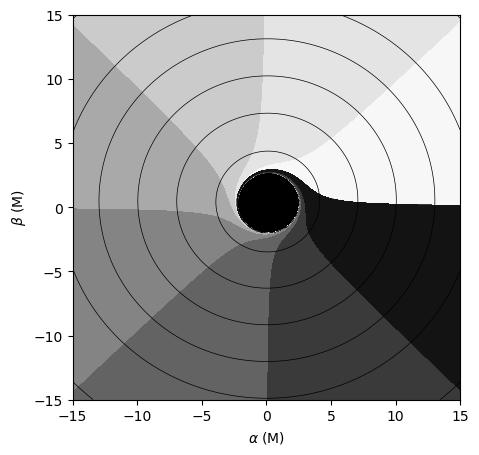

In [6]:
fig, ax = plt.subplots(figsize=[5,5],dpi=100)

ax.fill(hull_0i[:,0],hull_0i[:,1],color="k",linewidth=1,zorder=0)

CSphi=ax.contourf(phi0.reshape(N0,N0).T%(2*np.pi),cmap="Greys",levels=np.linspace(0,2*np.pi,9),extent=[-lim0,lim0,-lim0,lim0],origin="lower")
CSr=ax.contour(rs0.reshape(N0,N0).T,levels=[3,6,9,12,15,20],extent=[-lim0,lim0,-lim0,lim0],origin="lower",linewidths=0.5,colors='k')

ax.set_xlim(-lim0,lim0)
ax.set_ylim(-lim0,lim0)

ax.set_xlabel(r"$\alpha$"+" "+"(M)")
ax.set_ylabel(r"$\beta$"+" "+"(M)")

#plt.savefig('Rays.png',dpi=400,bbox_inches='tight')

# Calculating the emission angle ($\theta_{\rm B}$)

In [7]:
%time !python magneticangle.py

Magnetic Angle
using default lband
Reading file:  ./Results/LensingBands_a_0.9375_i_17.h5
using default rtray
Reading file:  ./Results/Rays_a_0.9375_i_17.h5
File  ./Results/MagneticAngle_a_0.9375_i_17.h5  created.
CPU times: user 17.8 ms, sys: 100 ms, total: 118 ms
Wall time: 2.01 s


# Setting the parameters of the astrophysical model

In [8]:
brightparams = {
    "nu0": 230e9,  # Observation frequency
    "mass": (MMkg * u.kg).to(u.g).value,  # Black hole mass
    "scale_height": .5,  # 2 scale_height
    "theta_b": 50.0 * (np.pi / 180),  # impact parameter, if assumed fixed
    "rb_0": 5,  # radius at which power laws equal base values
    "n_th0": 1.9e4,  # density power law base value
    "t_e0": 7e10,  # temperature power law base value
    "b_0": 8.13, # magnetic field power law base value
    "p_dens": -0.7,  # density power law exponent
    "p_temp": -1.0,  # temperature power law exponent
    "p_mag": -1.5,  # magnetic power law exponent
    "nscale": 0.3  # Scale of inoisy if used
}

funckeys = {
		"emodelkey" : 0, # emodelkey Emission Model choice, 0 = thermal ultrarelativistic, 1 = power law (1 is WIP)
        "bkey" : 2,      # Type of magnetic field profile , 0 = true function from Broderick and Loeb Eq. 3, 1 = power law with lmfit values of 0, 2 = power law from values set in brightparams
        "nnoisykey" : 0, # nnoisykey Inoisy density. 0 = no variability, 1 = inoisy variability
        "tnoisykey" : 0, # tnoisykey Inoisy temperature
        "bnoisykey" : 0, # bnoisykey Inoisy magnetic field
        "theta_bkey": 0, # Variable impact parameter, 0 for varied, 1 for fixed
}

In [9]:
cmd= fileloading.createIntensityArgs(brightparams,funckeys=funckeys) # create the neccesary command line argument

In [10]:
%time subprocess.run([cmd], shell=True)

Reading file:  ./Results/MagneticAngle_a_0.9375_i_17.h5
Reading file:  ./Results/LensingBands_a_0.9375_i_17.h5
Reading file:  ./Results/Rays_a_0.9375_i_17.h5
File  ./Results/Intensity_a_0.9375_i_17_t_0_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_0_tnkey_0_bnkey_0_magkey_0.h5  created.
CPU times: user 736 μs, sys: 5.22 ms, total: 5.96 ms
Wall time: 2.9 s


CompletedProcess(args=['python3 intensity.py --nu 230000000000.0 --mass 1.2924827500377644e+43 --scaleh 0.5 --thetab 0.8726646259971648 --rb0 5 --nth0 19000.0 --te0 70000000000.0 --b0 8.13 --pdens -0.7 --ptemp -1.0 --pmag -1.5 --nscale 0.3 --emodelkey 0 --bkey 2 --nnoisykey 0 --tnoisykey 0 --bnoisykey 0 --thetabkey 0 '], returncode=0)

# Load the images 

In [11]:
fnrays = fileloading.intensityNameNoUnits(brightparams,funckeys) # find created file na,e
    
print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

# Optically thin assumption
I0=h5f['bghts0'][:] # This implies I0 is 1 pass
I1=h5f['bghts1'][:]
I2=h5f['bghts2'][:]
totalThinImage = I0 + I1 + I2

# Optical depth included RTE solution 
Absorbtion_Image =h5f['bghts_full_absorbtion'][:]
h5f.close()

Reading file:  ./Results/Intensity_a_0.9375_i_17_t_0_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_0_tnkey_0_bnkey_0_magkey_0.h5


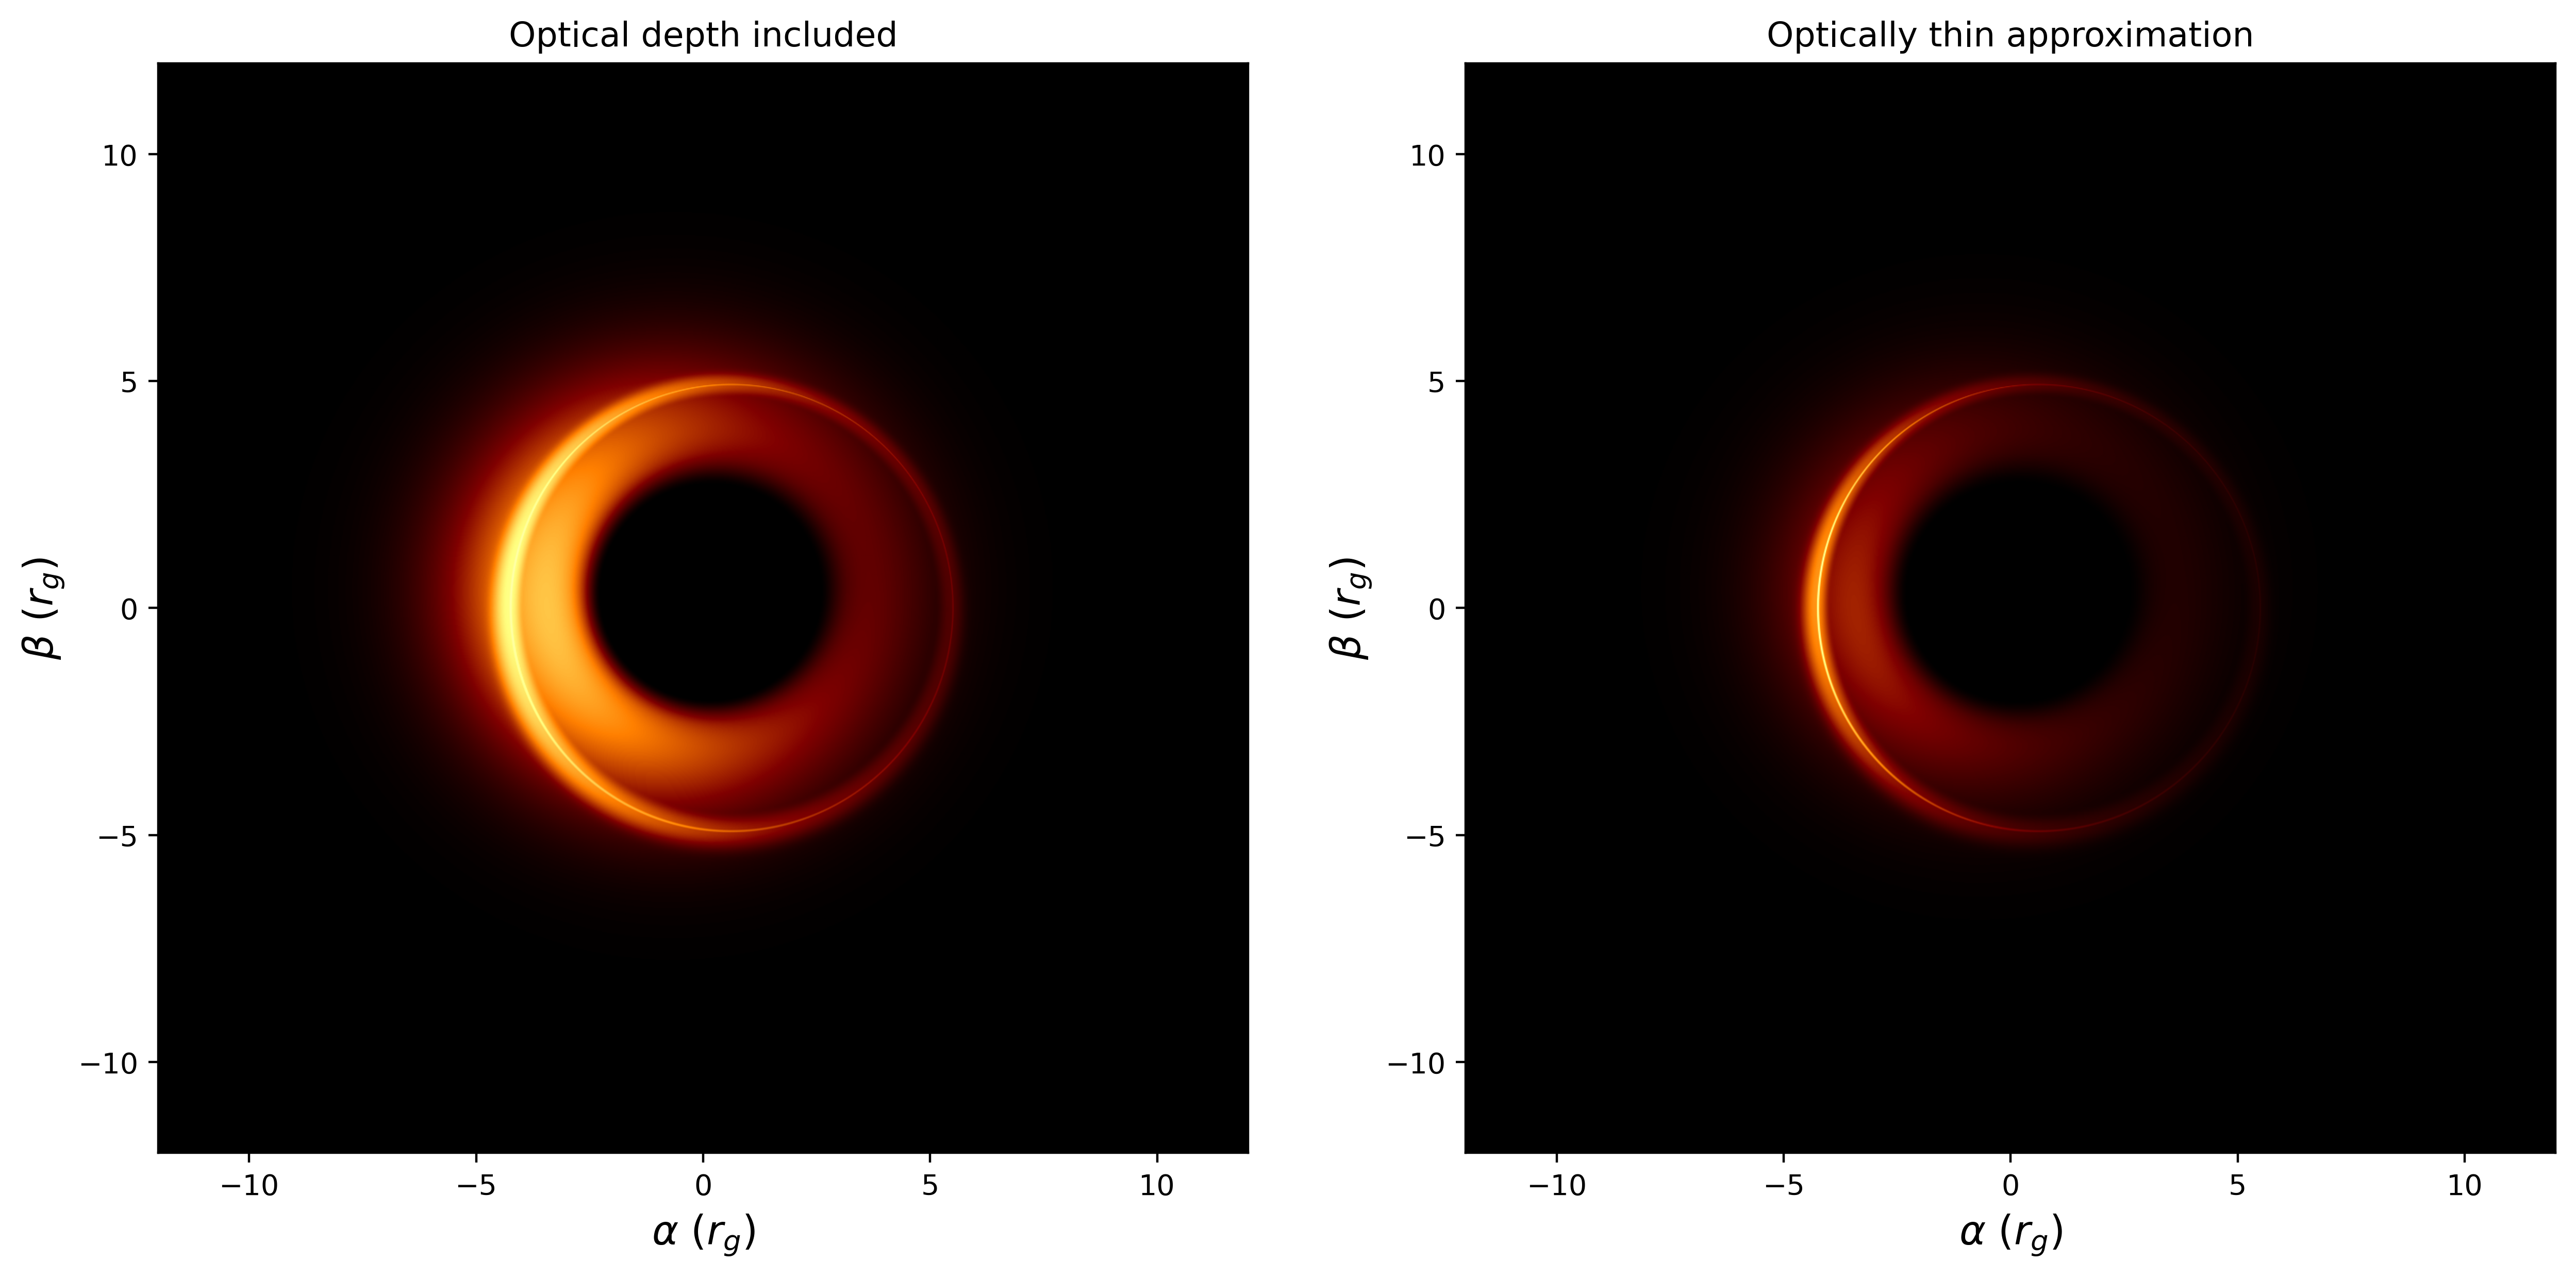

In [12]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=[15,7],dpi=400)

im0 = ax0.imshow(Absorbtion_Image, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],vmax=np.nanmax(Absorbtion_Image)*1.2)

ax0.set_xlim(-12,12) # units of M
ax0.set_ylim(-12,12) 
    
    
ax0.set_xlabel(r"$\alpha$"+" "+r"($r_g$)",fontsize=14)
ax0.set_ylabel(r"$\beta$"+" "+r"($r_g$)",fontsize=14)
ax0.set_title("Optical depth included")

im1 = ax1.imshow(totalThinImage, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],vmax=np.nanmax(totalThinImage)*1.2)

ax1.set_xlim(-12,12) # units of M
ax1.set_ylim(-12,12) 
    
    
ax1.set_xlabel(r"$\alpha$"+" "+r"($r_g$)",fontsize=14)
ax1.set_ylabel(r"$\beta$"+" "+r"($r_g$)",fontsize=14)
ax1.set_title("Optically thin approximation")

plt.savefig('TimeAveraged.png',dpi=400,bbox_inches='tight')

# Using inoisy to add time-variability

In [13]:
funckeys = {
		"emodelkey" : 0, # emodelkey Emission Model choice, 0 = thermal ultrarelativistic, 1 = power law (1 is WIP)
        "bkey" : 2,      # Type of magnetic field profile , 0 = true function from Broderick and Loeb eq. 3, 1 = power law with lmfit values of 0, 2 = power law from values set in brightparams
        "nnoisykey" : 1, # nnoisykey Inoisy density. 0 = no variability, 1 = variability
        "tnoisykey" : 1, # tnoisykey Inoisy temperature. 0 = no variability, 1 = variability
        "bnoisykey" : 1, # bnoisykey Inoisy magnetic field. 0 = no variability, 1 = variability
        "theta_bkey": 0, # Variable impact parameter, 0 for varied, 1 for fixed
}

cmd= fileloading.createIntensityArgs(brightparams,funckeys=funckeys) # create the neccesary command line argument

In [14]:
%time subprocess.run([cmd], shell=True)

Reading file:  ./Results/MagneticAngle_a_0.9375_i_17.h5
Reading file:  ./Results/LensingBands_a_0.9375_i_17.h5
Reading file:  ./Results/Rays_a_0.9375_i_17.h5
Computing Intensity

 Computing an image at time t=0.0 (M) 

File  ./Results/Intensity_a_0.9375_i_17_t_0.0_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1_magkey_0.h5  created.

 Computing an image at time t=5.26316 (M) 

File  ./Results/Intensity_a_0.9375_i_17_t_5.2631578947368425_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1_magkey_0.h5  created.

 Computing an image at time t=10.52632 (M) 

File  ./Results/Intensity_a_0.9375_i_17_t_10.526315789473685_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_pt

CompletedProcess(args=['python3 intensity.py --nu 230000000000.0 --mass 1.2924827500377644e+43 --scaleh 0.5 --thetab 0.8726646259971648 --rb0 5 --nth0 19000.0 --te0 70000000000.0 --b0 8.13 --pdens -0.7 --ptemp -1.0 --pmag -1.5 --nscale 0.3 --emodelkey 0 --bkey 2 --nnoisykey 1 --tnoisykey 1 --bnoisykey 1 --thetabkey 0 '], returncode=0)

In [15]:
imagestimes=np.linspace(i_tM+i_frame,f_tM,snapshots)
print("These are the computed times \n {}".format(imagestimes))

These are the computed times 
 [  0.           5.26315789  10.52631579  15.78947368  21.05263158
  26.31578947  31.57894737  36.84210526  42.10526316  47.36842105
  52.63157895  57.89473684  63.15789474  68.42105263  73.68421053
  78.94736842  84.21052632  89.47368421  94.73684211 100.        ]


Let us now select the second image to plot it indivdually

In [16]:
tsnapval=imagestimes[2]

In [17]:
fnrays = fileloading.intensityNameNoUnits(brightparams,funckeys,tsnap=tsnapval) # find created file na,e
    
print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

# Optically thin assumption
I0=h5f['bghts0'][:] # This implies I0 is 1 pass
I1=h5f['bghts1'][:]
I2=h5f['bghts2'][:]
totalThinImage = I0 + I1 + I2

# Optical depth included RTE solution 
Absorbtion_Image =h5f['bghts_full_absorbtion'][:]
h5f.close()

Reading file:  ./Results/Intensity_a_0.9375_i_17_t_10.526315789473685_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1_magkey_0.h5


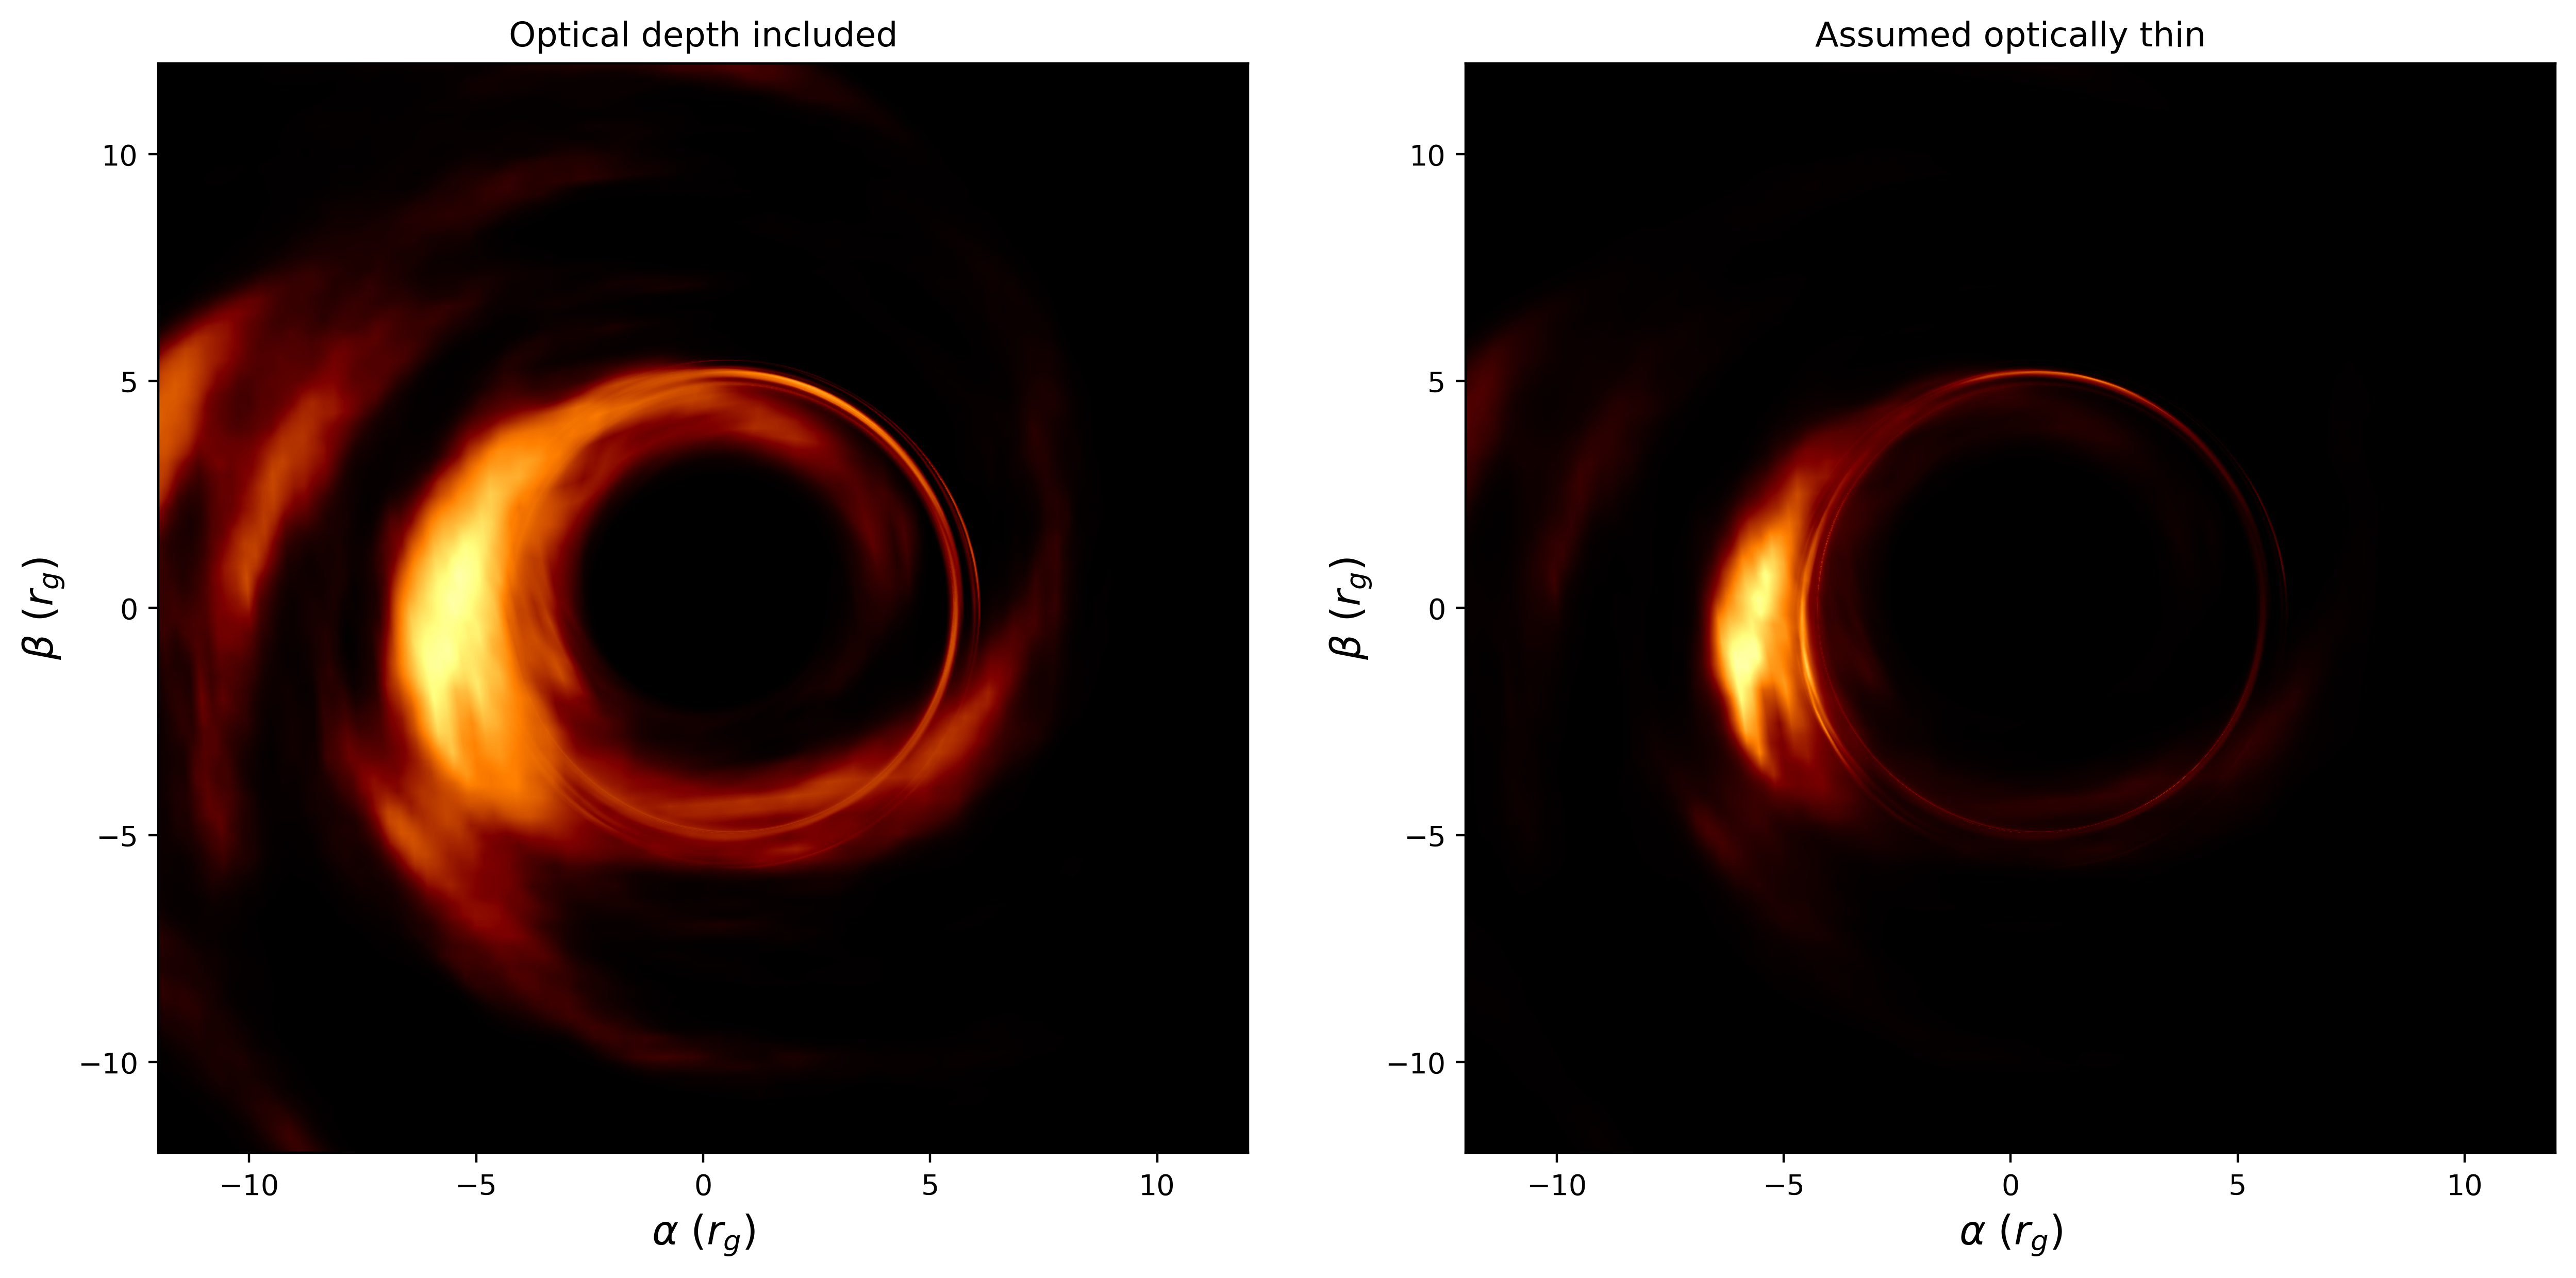

In [18]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=[15,7],dpi=400)

im0 = ax0.imshow(Absorbtion_Image, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],vmax=np.nanmax(Absorbtion_Image)*1.2)

#im0 = ax0.imshow(I1, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])

ax0.set_xlim(-12,12) # units of M
ax0.set_ylim(-12,12) 
    
ax0.set_xlabel(r"$\alpha$"+" "+r"($r_g$)",fontsize=14)
ax0.set_ylabel(r"$\beta$"+" "+r"($r_g$)",fontsize=14)
ax0.set_title("Optical depth included")

im1 = ax1.imshow(totalThinImage, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],vmax=np.nanmax(totalThinImage)*1.2)

ax1.set_xlim(-12,12) # units of M
ax1.set_ylim(-12,12) 
    
ax1.set_xlabel(r"$\alpha$"+" "+r"($r_g$)",fontsize=14)
ax1.set_ylabel(r"$\beta$"+" "+r"($r_g$)",fontsize=14)
ax1.set_title("Assumed optically thin")

plt.savefig('Snapshots_t_{}.png'.format(tsnapval),dpi=400,bbox_inches='tight')

# Movies

Let us now read all the images and produce a gif

In [19]:
fignames=[]
for tsnapval in imagestimes:

    fnrays = fileloading.intensityNameNoUnits(brightparams,funckeys,tsnap=tsnapval) # find created file na,e
    
    print("Reading file: ",fnrays)
    
    h5f = h5py.File(fnrays,'r')
    
    # Optically thin assumption
    I0=h5f['bghts0'][:] # This implies I0 is 1 pass
    I1=h5f['bghts1'][:]
    I2=h5f['bghts2'][:]
    totalThinImage = I0 + I1 + I2
    
    # Optical depth included RTE solution 
    Absorbtion_Image =h5f['bghts_full_absorbtion'][:]
    h5f.close()
    
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=[15,7],dpi=400)
    
    im0 = ax0.imshow(Absorbtion_Image, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],vmax=np.nanmax(Absorbtion_Image)*1.2)
    
    #im0 = ax0.imshow(I1, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
    
    ax0.set_xlim(-12,12) # units of M
    ax0.set_ylim(-12,12) 
    
    ax0.set_xlabel(r"$\alpha$"+" "+r"($r_g$)",fontsize=14)
    ax0.set_ylabel(r"$\beta$"+" "+r"($r_g$)",fontsize=14)
    ax0.set_title("Optical depth included")
    
    im1 = ax1.imshow(totalThinImage, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],vmax=np.nanmax(totalThinImage)*1.2)
    
    ax1.set_xlim(-12,12) # units of M
    ax1.set_ylim(-12,12) 
    
    ax1.set_xlabel(r"$\alpha$"+" "+r"($r_g$)",fontsize=14)
    ax1.set_ylabel(r"$\beta$"+" "+r"($r_g$)",fontsize=14)
    ax1.set_title("Assumed optically thin")

    fignames.append('Snapshots_t_{}.png'.format(tsnapval))
    
    plt.savefig('Snapshots_t_{}.png'.format(tsnapval),dpi=400,bbox_inches='tight')

    plt.close(fig)

with imageio.get_writer('BHMovie.gif', mode='I') as writer:
    for filename in fignames:
        image = imageio.imread(filename)
        writer.append_data(image)

# We delete the created images and just keep the GIF
for filename in set(fignames):
    os.remove(filename)

Reading file:  ./Results/Intensity_a_0.9375_i_17_t_0.0_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1_magkey_0.h5
Reading file:  ./Results/Intensity_a_0.9375_i_17_t_5.2631578947368425_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1_magkey_0.h5
Reading file:  ./Results/Intensity_a_0.9375_i_17_t_10.526315789473685_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1_magkey_0.h5
Reading file:  ./Results/Intensity_a_0.9375_i_17_t_15.789473684210527_nu_2.30000e+11_mass_1.29248e+43_scaleh_0.5_thetab_0.873_rb_5.0_nth0_1.9e+04_te0_7.0e+10_b0_8.130e+00_pdens_-0.7_ptemp_-1.0_pmag_-1.5_nscale_0.3_emkey_0_b

This is the resulting gif of the movie of these snapshots:

<img src="BHMovie.gif?raw=true" width="400" align="center">

# <center>Thanks for using <em>AART</em> multi-frequency!</center>

## License

MIT license

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit 
persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR 
PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE 
FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, 
ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN 
THE SOFTWARE.